# 卷积神经网络

In [1]:
from torchvision import datasets
import torchvision.transforms as transforms

data_path = "../data-unversioned/p1ch7/"
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

tensor_cifar10 = datasets.CIFAR10(data_path,
                                  train=True,
                                  download=False,
                                  transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path,
                                      train=False,
                                      download=False,
                                      transform=transforms.ToTensor())

transformed_cifar10 = datasets.CIFAR10(data_path,
                                       train=True,
                                       download=False,
                                       transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(
                                               (0.4914, 0.4822, 0.4465),
                                               (0.2470, 0.2435, 0.2616))
                                       ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in tensor_cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


在之前的例子中，我们使用了线性层构建了一个简单的模型，它可以拟合数据，这归功于线性层有很多可用于优化的参数。但是这个模型也存在一个问题，即这个模型在记忆训练集方面比在泛化鸟类与飞机的特性方面做的更好。

## 卷积介绍

如果想要识别与物体相应的图案，比如说天空中的一架飞机，我们可能需要看看附近的像素是怎样排列的，但我们对那些彼此相距很远的元素的组合并不关心。

为了将这种直觉转化为数学形式，我们可以计算像素与其相邻元素位置的加权和，而不是图像中所有元素的加权和。这相当于构建权重矩阵，每个输出特征和输出像素位置都有一个权重矩阵，其距离中心象素的一定距离以外的所有权重都为 0 。这仍然是一个加权和，即线性运算。

### 卷积的作用

前面我们提到了一个很重要的特性：我们希望这些局部位置对输出有影响，而不管它们在图中像的位置，也就是说希望神经网络存在平移不变性。以之前的区分鸟和飞机的数据集为例，将这个模型的输入图像作为矢量矩阵的目标，我们需要实现一个相当复杂的权重模式：大多数权重矩阵将被设置为 0 ，因为相对于输入像素对应的项，大多数像素距离输出像素太远而不会产生影响。对于其他权重矩阵，我们必须找一种方法使这些项保持同步，使它们对应输入和输出像素的相同位置，这意味着我们需要将它们初始化为相同值，并且确保在训练期间网络更新时这些像素绑定的权重保持不变。这样，我们就可以确保权重在邻域操作以影响局部模式，并且局部模式无论在哪都可以被识别出来。

当然，这种方法实操性不强，但幸运的是，在图像上有一个现成的、局部的、平移不变的线性操作：卷积。

卷积，更精确的讲：离散卷积，被定义为二维图像的权重矩阵的标量积，即核函数与输入中的每个邻域的标量积。将一个 3\*3 的内核作为一个二维张量：

``` py
weight = torch.tensor([w00, w01, w02],
                      [w10, w11, w12],
                      [w20, w21, w22])
```
以及一个一维的图像通道，M\*N 的图像：
``` py
image = torch.tensor([i00, i01, ... i0N],
                     [i10, i11, ... i1N],
                     ...
                     [iM0, iM1, ... iMN])
```
可以计算出输出图像的一个元素（无偏置）：

``` py
o11 = i11 * w00 + i12 * w01 + i13 * w02 + i21 * w10 + i22 * w11 + i23 * w12 + i31 * w20 + i32 * w21 + i33 * w22
```

![](./data/images/juanji.gif)

也就是说，我们平移输入图像 `i11` 位置上的核函数，然后将每个权重乘以输入图像在相应位置上的值。因此，通过平移所有输入位置上的内核并执行加权和来创建输出图像。对于多通道图像，如 RGB 图像，权重矩阵将是一个 `3*3*3` 的矩阵：每个通道对应一组权重，他们共同作用于输出值。

注意，就像是 `nn.Linear` 权重矩阵中的元素一样。核中的权重是事先不知道的，他们是随机初始化的，并通过反向传播进行更新。还需要注意，相同的核以及核中的权重在整幅图像中被重用，这意味着每个权重的使用都有一个跨越整个图像的历史值，因此关于卷积权值的损失导数来自整个图像的贡献。

现在可以看到它和之前提到的内容的联系了：卷积等价于进行多重线性操作，他们的权重除了个别像素外都为 0 ，并在训练期间接受相同的更新。

综上所述，我们可以得到卷积的以下特征：

* 邻域的局部操作
* 平移不变性
* 模型的参数大幅减少

## 卷积实战

`torch.nn` 模块提供了一维、二维、三维的卷积，其中 `nn.Conv1d` 用于时间序列， `nn.Conv2d` 用于图像， `nn.Conv3d` 用于体数据和视频。

对于 `CIFAR-10` 数据，我们将使用 `nn.Conv2d` ，提供给 `nn.Conv2d` 的参数至少包括输入特征（或通道，因为我们处理的是多通道图像，也就是说，每个像素有多个值）的数量、输入特征的数量以及核的大小等。例如，对于第一个巻积模块，每个像素有 3 个输入特征（RGB 通道），输出特征具有任意数量的通道/特征数。输出通道/特征越多，说明网络的容量越大，我们能借助于这些通道检测到很多不同类型的特征

In [2]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

由于卷积核在各个方向上大小相同是很常见的，所以 `PyTorch` 提供了一种快捷方式：每当二维卷积指定 `kernel_size=3` 是为 3\*3 的卷积矩阵。

那么权重张量的形状应当如何呢？卷积核大小为 3\*3 ，所以权重应当由多个 3\*3 部分组成。对于单个像素输出值，在三个输入通道的情况下我们的权重张量为 3\*3\*3 ，最后我们有和输出通道一样多的多通道，即完整的权重张量为 16\*3\*3\*3 ，而偏执张量为 16 ，可以验证一下：

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

接下来可以通过 `cifar-10` 数据集测试以下：

In [4]:
from matplotlib import pyplot as plt

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

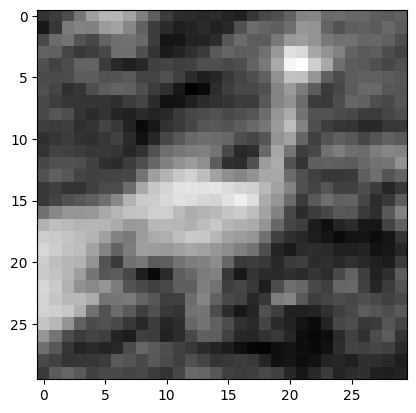

In [5]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


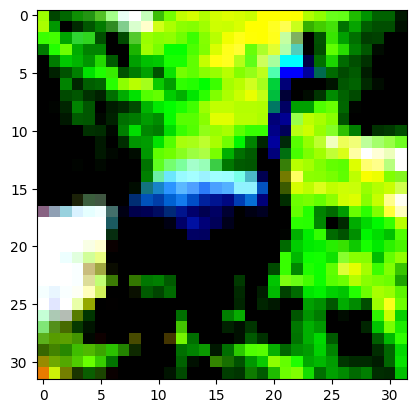

In [6]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

从上可以看出输出大小为 `torch.Size([1, 16, 30, 30]))` ，在这过程中，我们丢失了一些像素。造成这个结果的原因是卷积核应用到图像上时，要求其在所有方向上都有邻域，比如在 `i00` 位置，我们只有卷积核右侧和下侧的像素。

不过， `PyTorch` 提供了一种填充图像的功能——通过在边界周围填充重影像素来填充图像。就卷积而言，这些重影像素的值为 0 。

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

填充卷积主要有两个原因，首先，这样做可以帮助分离卷积操作和改变图像大小操作，其次，当存在更复杂的结构时，有可能希望卷积之前和之后的张量大小是一致的，方便后续相加或取差值。

### 用卷积检测特征

在之前的内容中说过卷积的权重和偏置都是通过反向传播学习的，但是我们也可以通过手动设置权重来处理卷积，先来看看会发生什么。

为了消除所有干扰的因素，首先将偏置设为 0 ，然后将权重设置为一个常数值，这样输出中的每一个像素都能得到其相邻像素的均值：

In [8]:
import torch
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

<function matplotlib.pyplot.show(close=None, block=None)>

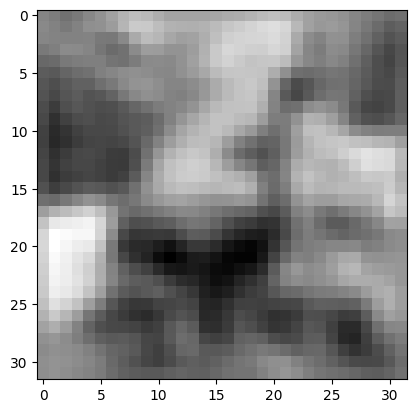

In [9]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show

可以看出滤波器会产生模糊的图像，毕竟输出的每个像素都是输入邻域的平均值，因此输出中的像素都是相关的，并且变化更加平滑。

接下来尝试一些不同的东西：

<function matplotlib.pyplot.show(close=None, block=None)>

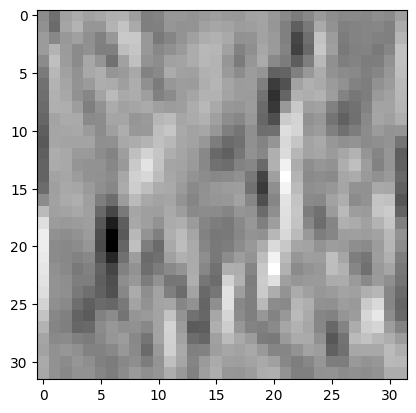

In [10]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0, 1.0],
        [-1.0, 0, 1.0],
        [-1.0, 0, 1.0],
    ])
    conv.bias.zero_()
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show

上面这个例子中，卷积核增强了垂直边缘，当然我们还可以构建更复杂的滤波器，例如检测水平或对角线边缘等，检测意味着输出较高的峰值。

#### 深度和池化

在之前的内容中我们从全连接转换成了卷积，实现了局部性和平移不变性，其次建议使用小的卷积核，以实现峰值局部性。但是目前还存在一个问题：我们需要检测特征的整体情况如何，因为一般情况下存在对象跨越了多个像素、大于卷积核的大小，这种情况下我们就需要考虑如何才能让卷积核看到更大范围的图像。

一种方法是使用大的卷积核，对于一个 32\*32 的图像，我们最大可使用 32\*32 的卷积核，但这就和全连接反射变换差不多了，同时失去了卷积所有的良好特性；而另一种方法就是在卷积之后堆叠另一个卷积，同时在卷积之间进行下采样。

原则上，下采样可以以不同的方式进行。将图像缩放一半相当于取 4 个相邻像素作为输出，产生一个像素作为输出，采样的方法如下：

* 取 4 个像素的平均值。
* 取 4 个像素的最大值。
* 使用带步长的卷积。

接下来，我们将重点讨论最大池化法：

![](data/images/max_pool.png)

上图显示了显示了最常见的设置，即取不重叠的 2\*2 个分片，并将每个分片上的最大值作为缩小后的新像素。

直观的说，卷积层的输出图像，尤其是当它们后面更着一个激活层，在检测到与估计值对应的某些特征时，往往具有很高的幅值，而通过保持 2\*2 邻域中的最大值作为下采样的输出，可以确保所发现的特征在下采样后依旧存在。

最大池化由 `nn.MaxPool2d` 模块提供，与卷积一样，也有一维和三维版本。它将池化操作的领域大小作为输入，如果我们想让图像缩小一半，可以让核大小为 2 ，现在先验证一下：

In [11]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

有了这些构建模块，现在就可以继续构建神经网络来识别鸟和飞机了：

In [12]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    #...
)

在上面这个模型中，第一个卷积将从 3 个 RGB 通道带到 16 个 RGB 通道，因此会给网络一个来生成 16 个独立的特征，希望能够区分鸟和飞机的一些低级特征。然后应用 `Tanh` 激活函数。把激活函数得到的有 16 个通道的、32\*32 的图像被第一个 `MaxPool2d` 池化成有 16 个通道的 、16\*16的图像。随后把下采样图像应用到另一个卷积，产生一个有 8 个通道的、16\*16的输出，如果幸运的话，这个输出将带包含更高级的特征。同样的，将卷积输出应用 `Tanh` 激活函数，然后将其池化到有 8 个通道的、 8\*8 的输出。

当输入图像被缩减为 8\*8 的特征集后，我们希望网络能够输出一些概率，这样我们就可以将这些概率输入到负对数似然中，但是这需要概率是一维向量中的一对数字，但是在这里我们仍然在处理多通道的二维特征。所以在此需要将 8 个通道的、 8\*8 的图像转换为一维向量，并使用全连接层完成整个网络：

In [13]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    #...
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
    nn.LogSoftmax(),
)

需要注意的是，线性层的大小取决于 `MaxPool2d` 预期的输出大小： 8\*8\*8=512 。现在计算一下这个小模型的参数数目：

In [14]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

可以看到整个模型的参数要比之前的全连接层少得多，这是非常合理的。如果需要增加模型的容量，则可以增加卷积层的输出通道数，但这也会导致线性层大小的增加。

需要注意的是现在这个模型暂时还不可用，因为中间少了将 8\*8\*8 图像转为 1\*512 张量的步骤。

In [15]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
    nn.Softmax(dim=1),
)

In [16]:
output = model(img.unsqueeze(0))
output

tensor([[0.5615, 0.4385]], grad_fn=<SoftmaxBackward0>)

## 子类化 nn.Module

在开发神经网络时，有时候会遇到这种情况：需要使用一些预设模块没有的东西。在这种时候就需要通过子类化 `nn.Module` 解决这个问题。

为了子类化 `nn.Module` ，至少需要定义一个 `forward()` 方法，该方法接收模块的输入并返回输出。这就是定义模块计算的地方。

通常情况下，运算将会使用到其它模块，例如内置的卷积或自定义的模块。为了包含这些子模块，通常需要在构造函数 `__init__()` 中定义它们，并将它们复制给 `self` 以便在 `forward()` 方法中使用它们。同时，它们将在模块的整个生命周期中保存他们的参数。

接下来，尝试将上面的 `Sequential` 子类化：

In [17]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        output = self.pool1(self.act1(self.conv1(x)))
        output = self.pool2(self.act2(self.conv2(output)))
        output = output.view(-1, 8 * 8 * 8)
        output = self.act3(self.fc1(output))
        output = self.soft(self.fc2(output))

        return output

`Net` 类相当于之前使用 `nn.Sequential` 构建的模型，但是通过显示的编写 `forward()` 方法，我们可以操作 `self.pool2` 的输出，并调用 `view` 方法将其转换成 `B*N` 的张量。需要注意的是，在调用 `view` 时将批处理维度设置为 -1 ，因为原则上我们不知道批次中有多少样本。

有意思的是，给 `nn.Module` 的一个属性分配一个 `nn.Moudule` 实例时，会自动注册为子模块。不过需要注意：子模块必须是顶级属性，而不是隐藏在 `list` 或 `dict` 实例中，否则优化器将无法定位子模块和它们的参数，对于这两种场景，`PyTorch` 也提供了 `nn.ModuleList` 和 `nn.ModuleDict` 支持。

但是在上面的这个模块中还注册了一些没有参数的子模块，这些子模块 `PyTorch` 也都提供了函数式 API 。这里的函数式指的是“没有内部状态”。接下来看看使用函数式 API 的 Module ：

In [18]:
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):

        output = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        output = F.max_pool2d(torch.tanh(self.conv2(output)), 2)
        output = output.view(-1, 8 * 8 * 8)
        output = torch.tanh(self.fc1(output))
        output = F.softmax(self.fc2(output), dim=1)

        return output

接下来测试一下：

In [19]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.4525, 0.5475]], grad_fn=<SoftmaxBackward0>)

## 开始训练

到目前为止，我们已经有了一个完整的模型，现在可以组装完整的训练循环了。

回想一下，在之前的训练中的核心是两个嵌套的循环：一个是快跨迭代周期的外部循环，另一个是从数据集生成批次的 `Dataloader` 内部循环，而在每个循环中，我们都需要这样做：

* 通过模型提供输入
* 计算损失
* 将之前的梯度都更新为 0
* 调用 `loss.backward()` 来计算损失相对所有参数的梯度
* 让优化器朝着更低的损失迈进

In [20]:
def train(n_epochs, data_loader, loss_fn, optimizer, model):
    for epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in data_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            loss_train += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch == 1 or epoch % 10 == 0:
            print("Epoch: %d, Loss: %f" %
                  (epoch, float(loss_train) / len(data_loader)))

接下来进行初始化并开始训练：

In [21]:
import torch.optim as optim
train_dataloader = torch.utils.data.DataLoader(cifar2,batch_size=64,shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(),lr=1e-2)
loss_fn = nn.NLLLoss()
train(n_epochs=100,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,model=model)

Epoch: 0, Loss: -0.579724
Epoch: 1, Loss: -0.706121
Epoch: 10, Loss: -0.785566
Epoch: 20, Loss: -0.804481
Epoch: 30, Loss: -0.823872
Epoch: 40, Loss: -0.837174
Epoch: 50, Loss: -0.848292
Epoch: 60, Loss: -0.861396
Epoch: 70, Loss: -0.869434
Epoch: 80, Loss: -0.872885
Epoch: 90, Loss: -0.877691


接下来定义测试函数：

In [22]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)

                # 输出的 outputs 是一个二维张量，第 0 为是批次，第二维则是单个图像预测的各个类别的概率，这里输出的是最大概率的索引，即类别
                _, predicted = torch.max(outputs, dim=1)
                # 计算经过模型处理的图像的数量
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {} : {:2f}".format(name, correct / total))

In [23]:
val_loader = torch.utils.data.DataLoader(cifar2_val,
                                         batch_size=64,
                                         shuffle=True)
validate(model=model, train_loader=train_dataloader, val_loader=val_loader)

Accuracy train : 0.887400
Accuracy val : 0.685000


可以看出，这个模型的准确率要比全连接模型好的多，并且参数量也更少。这告诉我们，通过局部性和平移不变性，这个模型在识别图像主题方面做得更好。

## 模型设计

在之前的内容中，我们将模型构建成了一个 `nn.Module` 的子类，它是除最简单模型之外的所有模型的标准。然后成功的训练了该模型。我们已经可以建立一个前向卷积神经网络并训练它成功地进行分类。现在的问题是：如果遇到更复杂的问题应该怎么办？不可置否的是，我们之前用于区分鸟和飞机的数据集并不是很复杂，对于其它更大、更复杂的图像，获取正确的答案将取决于多种视觉线索，通常是分层组织的。例如，在预测一个深色砖块形状的物体是遥控器还是手机时，网络可能会寻找类似“屏幕”的东西。

另外，图像也并不是我们在现实生活中唯一关注的焦点，在现实世界中，我们还有表格数据、序列和文本等。神经网络的前景是在给定的结构和适当的损失函数的情况下，有足够的灵活性来解决这些类型数据的所有问题。

### 增加容量：宽度

网络宽度：即每层神经元数，或每个卷积的通道数。在 `PyTorch` 中我们可以很容易的使模型变宽：只需要在第一个卷积中指定更多的输出通道，并相应的增加后续的层数。不过需要注意是：一旦切换到全连接层，我们将得到一个更长的向量。

In [24]:
class NetWidth(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        output = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        output = F.max_pool2d(torch.tanh(self.conv2(output)), 2)
        output = output.view(-1, 16 * 8 * 8)
        output = torch.tanh(self.fc1(output))
        output = self.fc2(output)
        return output

如果想避免在模型中硬编码数字，也可以很容易的将一个参数传递给 `__init__()` 并参数化宽度：

In [25]:
class NetWidth(nn.Module):

    def __init__(self, n_chans=32):
        super().__init__()
        self.n_chans = n_chans
        self.conv1 = nn.Conv2d(3, n_chans, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans, n_chans // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(n_chans // 2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        output = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        output = F.max_pool2d(torch.tanh(self.conv2(output)), 2)
        output = output.view(-1, self.n_chans // 2 * 8 * 8)
        output = torch.tanh(self.fc1(output))
        output = self.fc2(output)
        return output

为每一层指定的通道和特征数量与模型中参数的数量直接相关，在其他条件相同的情况下，他们会增加模型容量。

模型容量越大，模型所能管理的输入的可变性就越大。但与此同时，模型出现过拟合的可能性就越大，因为模型可以使用更多的参数来记忆输入不重要的部分。对抗过拟合的最好办法是增加样本数量，或者在没有新数据的情况下，通过人工修改相同的数据来增加现有数据。

### 正则化

训练模型涉及两个关键步骤，一是优化，需要减少在训练集上的损失；二是泛化，因为模型不仅要处理训练集，还要处理之前没见过的验证集等。

#### 权重惩罚

稳定泛化的第一种方式就是在损失中添加一个正则项。这个设计是为了减小模型本身的权重，从而限制训练对它们的影响，换句话说，这是对较大权重的惩罚。这使得损失更平滑，并且从拟合单个样本中获得的收益相对较少。这类流行的正则化项是 L2 正则化，它是模型中所有权重的平方和，而 L1 正则化是模型中所有权中的绝对值之和。它们都通过一个因子进行缩放，这个因子是我们在训练前设置的超参数。

L2 正则化也称为权重衰减，它对参数 `w_i` 的负梯度为 `-2*lambda*w_i` ，其中 `lambda` 就是前面提到的超参数。因此，在损失函数中加入 L2 正则化，相当于在优化步骤中将每个权重按其当前值的比例缩减，注意，权重衰减适用于网络的所有参数。

在 `PyTorch` 中，可以很容易的在损失中添加一项来实现正则化：计算完损失后，无论损失函数是什么，我们都可以对模型的参数进行迭代，将它们的各自平方或绝对值相加，然后反向传播。

In [26]:
def train_loop(n_epochs, data_loader, loss_fn, optimizer, model):
    for epoch in range(n_epochs):
        loss_train = 0.0
        for imgs, labels in data_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            loss_train += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch == 1 or epoch % 10 == 0:
            print("Epoch: %d, Loss: %f" %
                  (epoch, float(loss_train) / len(data_loader)))

不过， `PyTorch` 中的 SGD 优化器已经有了一个 `weight_decay` 参数，该参数对应 `2*lambda`，它在前面描述的更新中直接执行权重衰减，它完全等价于加入 L2 范数。

#### Dropout

2014年，一篇论文提出了一种对抗过拟合的有效策略，题目为 "Dropout:A Simple Way to Prevent Neural Network from Overfiting"。Dropout背后的思想其实很简单：将网络每轮训练迭代中的神经元随机部分清零。

Dropout 在每次迭代中有效地生成具有不同神经元拓扑的模型，使得模型中的神经元在国拟合过程中协调记忆过程的机会更少。另一种观点是， Dropout 在整个网络中干扰了模型生成的特征，产生了一种接近于增强的效果。

在 `PyTorch` 中，可以通过在非线性激活函数与后面的线性或卷积模块之间添加一个 `nn.Dropout` 模块在模型中实现 Dropout （对卷积模块也有对应的版本），这个模块需要一个制定输入归零的概率：

In [27]:
class NetWidth(nn.Module):

    def __init__(self, n_chans=32):
        super().__init__()
        self.n_chans = n_chans
        self.conv1 = nn.Conv2d(3, n_chans, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans, n_chans // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(n_chans // 2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        output = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        output = self.conv1_dropout(output)
        output = F.max_pool2d(torch.tanh(self.conv2(output)), 2)
        output = self.conv2_dropout(output)
        output = output.view(-1, self.n_chans // 2 * 8 * 8)
        output = torch.tanh(self.fc1(output))
        output = self.fc2(output)
        return output

注意：在训练过程中 Dropout 通常是活跃的，而在生产环境或评估模型时，会绕过 Dropout，或等效的给其分配一个等于 0 的概率。这是通过 Dropout 的 train 属性控制的，也可通过 `PyTorch` 中的 `model.train()` 